In [165]:
from google.colab import files
uploaded = files.upload()

Saving SAB.csv to SAB.csv


In [166]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

In [168]:
df = pd.read_csv('SAB.csv')
df["Price"] = df["Price"].str.replace(',', '').astype(float)
df1=df.reset_index()['Price']

In [169]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

<h1># 4. Split the data into training, testing, and validation arcording to 7:2:1

In [170]:
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [171]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [172]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [173]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [174]:
# 8. Define LSTM Model

model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [175]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
13/13 [==============================] - 2s 71ms/step - loss: 0.0732 - val_loss: 0.0124
Epoch 2/100
13/13 [==============================] - 1s 54ms/step - loss: 0.0124 - val_loss: 3.1076e-04
Epoch 3/100
13/13 [==============================] - 1s 53ms/step - loss: 0.0039 - val_loss: 3.3869e-04
Epoch 4/100
13/13 [==============================] - 1s 57ms/step - loss: 0.0028 - val_loss: 4.0574e-04
Epoch 5/100
13/13 [==============================] - 1s 52ms/step - loss: 0.0020 - val_loss: 2.9898e-04
Epoch 6/100
13/13 [==============================] - 1s 55ms/step - loss: 0.0017 - val_loss: 2.6698e-04
Epoch 7/100
13/13 [==============================] - 1s 54ms/step - loss: 0.0016 - val_loss: 2.4243e-04
Epoch 8/100
13/13 [==============================] - 1s 48ms/step - loss: 0.0015 - val_loss: 2.3655e-04
Epoch 9/100
13/13 [==============================] - 1s 44ms/step - loss: 0.0014 - val_loss: 2.2694e-04
Epoch 10/100
13/13 [==============================] - 1s 44ms/step -

In [176]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

1/1 [==============================] - 0s 36ms/step


In [177]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val, yval, ytest
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)
ytest = scaler.inverse_transform(ytest.reshape(-1,1))
yval = scaler.inverse_transform(yval.reshape(-1,1))

In [178]:
from sklearn.metrics import mean_absolute_error
# 12. Đánh giá độ chính xác thuật toán bằng RMSE , MAE, MAPE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))


mae_test = mean_absolute_error(ytest, y_pred)
mae_val = mean_absolute_error(yval, y_pred_val)

mape_test = np.mean(np.abs((ytest - y_pred) / ytest)) * 100
mape_val = np.mean(np.abs((yval - y_pred_val) / yval)) * 100

print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print("Validate MAE: ", mae_val)
print("Test MAE: ", mae_test)
print("Validate MAPE: ", mape_val)
print("Test MAPE: ", mape_test)


Validation RMSE: 982.5436867230802
Testing RMSE: 1527.8535214672388
Validate MAE:  706.1093749999998
Test MAE:  1096.752555941358
Validate MAPE:  1.232945391201037
Test MAPE:  1.5189448251502031


In [179]:
# 13. Dự báo 90 ngày tiếp theo
x_input=val_data[32:].reshape(1,-1)
x_input.shape
print(len(val_data))
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<90):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


132
[0.03210589]
101
1 day input [0.0397463  0.04059197 0.0384778  0.03509514 0.03763214 0.03636364
 0.03340381 0.03340381 0.03340381 0.03382664 0.03763214 0.03551797
 0.03298097 0.03298097 0.02663848 0.02029598 0.02283298 0.01987315
 0.01606765 0.02114165 0.01902748 0.01902748 0.02029598 0.02241015
 0.02494715 0.02325581 0.02283298 0.02579281 0.02367865 0.02325581
 0.01902748 0.01733615 0.01606765 0.02198732 0.02536998 0.02579281
 0.02452431 0.02706131 0.0372093  0.03424947 0.03171247 0.02875264
 0.02790698 0.03002114 0.02621564 0.02325581 0.01775899 0.01860465
 0.01860465 0.01987315 0.02029598 0.01902748 0.01860465 0.02114165
 0.01987315 0.01775899 0.01818182 0.01649049 0.01479915 0.01691332
 0.01522199 0.01183932 0.01057082 0.01183932 0.01226216 0.01479915
 0.01057082 0.00972516 0.00634249 0.         0.00295983 0.00211416
 0.00465116 0.00803383 0.00803383 0.01733615 0.01775899 0.01902748
 0.02198732 0.02706131 0.02156448 0.02156448 0.01860465 0.01945032
 0.02156448 0.02114165 0.0236

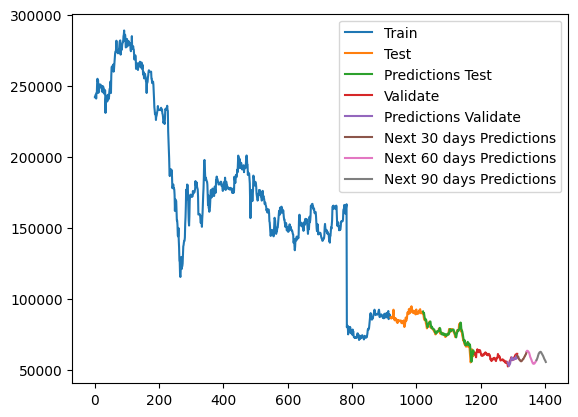

In [180]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))

val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))

val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)

next_30_days_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(next_30_days_index, scaler.inverse_transform(lst_output[:30]))

next_60_days_index = pd.RangeIndex(start=len(df1)+29, stop=len(df1)+59, step=1)
plt.plot(next_60_days_index, scaler.inverse_transform(lst_output[30:60]))

next_90_days_index = pd.RangeIndex(start=len(df1)+59, stop=len(df1)+89, step=1)
plt.plot(next_90_days_index, scaler.inverse_transform(lst_output[60:]))

plt.legend(['Train','Test','Predictions Test','Validate','Predictions Validate','Next 30 days Predictions','Next 60 days Predictions','Next 90 days Predictions'])

plt.show()

<h1># 4. Split the data into training, testing, and validation arcording to 5:3:2

In [181]:
train_size = int(0.5 * len(df1))
test_size = int(0.3 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [182]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [183]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [184]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [185]:
# 8. Define LSTM Model

model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [186]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
9/9 [==============================] - 2s 54ms/step - loss: 0.1328 - val_loss: 0.1012
Epoch 2/100
9/9 [==============================] - 0s 27ms/step - loss: 0.0333 - val_loss: 0.0215
Epoch 3/100
9/9 [==============================] - 0s 28ms/step - loss: 0.0191 - val_loss: 0.0208
Epoch 4/100
9/9 [==============================] - 0s 27ms/step - loss: 0.0080 - val_loss: 0.0059
Epoch 5/100
9/9 [==============================] - 0s 29ms/step - loss: 0.0035 - val_loss: 0.0120
Epoch 6/100
9/9 [==============================] - 0s 32ms/step - loss: 0.0024 - val_loss: 0.0111
Epoch 7/100
9/9 [==============================] - 0s 29ms/step - loss: 0.0020 - val_loss: 0.0085
Epoch 8/100
9/9 [==============================] - 0s 27ms/step - loss: 0.0018 - val_loss: 0.0050
Epoch 9/100
9/9 [==============================] - 0s 26ms/step - loss: 0.0017 - val_loss: 0.0037
Epoch 10/100
9/9 [==============================] - 0s 32ms/step - loss: 0.0015 - val_loss: 0.0032
Epoch 11/100
9/9 [=

In [187]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

6/6 [==============================] - 0s 14ms/step


In [188]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val, yval, ytest
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)
ytest = scaler.inverse_transform(ytest.reshape(-1,1))
yval = scaler.inverse_transform(yval.reshape(-1,1))

In [189]:
from sklearn.metrics import mean_absolute_error
# 12. Đánh giá độ chính xác thuật toán bằng RMSE , MAE, MAPE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))


mae_test = mean_absolute_error(ytest, y_pred)
mae_val = mean_absolute_error(yval, y_pred_val)

mape_test = np.mean(np.abs((ytest - y_pred) / ytest)) * 100
mape_val = np.mean(np.abs((yval - y_pred_val) / yval)) * 100

print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print("Validate MAE: ", mae_val)
print("Test MAE: ", mae_test)
print("Validate MAPE: ", mape_val)
print("Test MAPE: ", mape_test)

Validation RMSE: 14461.851001257122
Testing RMSE: 10958.338967633403
Validate MAE:  14372.041890337423
Test MAE:  9373.414115827645
Validate MAPE:  24.16055200854802
Test MAPE:  11.167017606602139


In [190]:
# 13. Dự báo 90 ngày tiếp theo

x_input=val_data[164:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]

n_steps=100
i=0
while(i<90):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

[0.09603537]
101
1 day input [0.0397463  0.04059197 0.0384778  0.03509514 0.03763214 0.03636364
 0.03340381 0.03340381 0.03340381 0.03382664 0.03763214 0.03551797
 0.03298097 0.03298097 0.02663848 0.02029598 0.02283298 0.01987315
 0.01606765 0.02114165 0.01902748 0.01902748 0.02029598 0.02241015
 0.02494715 0.02325581 0.02283298 0.02579281 0.02367865 0.02325581
 0.01902748 0.01733615 0.01606765 0.02198732 0.02536998 0.02579281
 0.02452431 0.02706131 0.0372093  0.03424947 0.03171247 0.02875264
 0.02790698 0.03002114 0.02621564 0.02325581 0.01775899 0.01860465
 0.01860465 0.01987315 0.02029598 0.01902748 0.01860465 0.02114165
 0.01987315 0.01775899 0.01818182 0.01649049 0.01479915 0.01691332
 0.01522199 0.01183932 0.01057082 0.01183932 0.01226216 0.01479915
 0.01057082 0.00972516 0.00634249 0.         0.00295983 0.00211416
 0.00465116 0.00803383 0.00803383 0.01733615 0.01775899 0.01902748
 0.02198732 0.02706131 0.02156448 0.02156448 0.01860465 0.01945032
 0.02156448 0.02114165 0.02367865

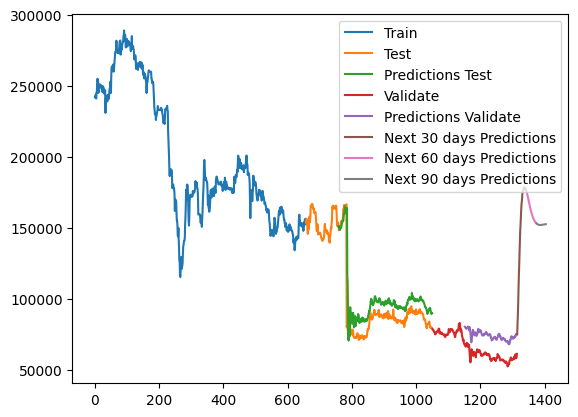

In [191]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))

val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))

val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)

next_30_days_index = pd.RangeIndex(start=len(df1), stop=len(df1)+30, step=1)
plt.plot(next_30_days_index, scaler.inverse_transform(lst_output[:30]))

next_60_days_index = pd.RangeIndex(start=len(df1)+30, stop=len(df1)+60, step=1)
plt.plot(next_60_days_index, scaler.inverse_transform(lst_output[30:60]))

next_90_days_index = pd.RangeIndex(start=len(df1)+60, stop=len(df1)+90, step=1)
plt.plot(next_90_days_index, scaler.inverse_transform(lst_output[60:]))

plt.legend(['Train','Test','Predictions Test','Validate','Predictions Validate','Next 30 days Predictions','Next 60 days Predictions','Next 90 days Predictions'])

plt.show()


<h1># 4. Split the data into training, testing, and validation arcording to 6:3:1

In [192]:
train_size = int(0.6 * len(df1))
test_size = int(0.3 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [193]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [194]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [195]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [196]:
# 8. Define LSTM Model

model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [197]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
11/11 [==============================] - 2s 51ms/step - loss: 0.0234 - val_loss: 0.0145
Epoch 2/100
11/11 [==============================] - 0s 28ms/step - loss: 0.0044 - val_loss: 0.0243
Epoch 3/100
11/11 [==============================] - 0s 28ms/step - loss: 0.0016 - val_loss: 0.0068
Epoch 4/100
11/11 [==============================] - 0s 26ms/step - loss: 8.8186e-04 - val_loss: 9.9565e-04
Epoch 5/100
11/11 [==============================] - 0s 27ms/step - loss: 5.7867e-04 - val_loss: 2.0716e-04
Epoch 6/100
11/11 [==============================] - 0s 30ms/step - loss: 5.4351e-04 - val_loss: 1.3884e-04
Epoch 7/100
11/11 [==============================] - 0s 27ms/step - loss: 5.2264e-04 - val_loss: 1.5870e-04
Epoch 8/100
11/11 [==============================] - 0s 30ms/step - loss: 5.1620e-04 - val_loss: 2.7063e-04
Epoch 9/100
11/11 [==============================] - 0s 30ms/step - loss: 5.2345e-04 - val_loss: 2.2433e-04
Epoch 10/100
11/11 [==============================] 

In [198]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

1/1 [==============================] - 0s 36ms/step


In [199]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val, yval, ytest
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)
ytest = scaler.inverse_transform(ytest.reshape(-1,1))
yval = scaler.inverse_transform(yval.reshape(-1,1))

In [200]:
from sklearn.metrics import mean_absolute_error
# 12. Đánh giá độ chính xác thuật toán bằng RMSE , MAE, MAPE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))


mae_test = mean_absolute_error(ytest, y_pred)
mae_val = mean_absolute_error(yval, y_pred_val)

mape_test = np.mean(np.abs((ytest - y_pred) / ytest)) * 100
mape_val = np.mean(np.abs((yval - y_pred_val) / yval)) * 100

print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print("Validate MAE: ", mae_val)
print("Test MAE: ", mae_test)
print("Validate MAPE: ", mape_val)
print("Test MAPE: ", mape_test)

Validation RMSE: 20186.11665800968
Testing RMSE: 8592.459888779711
Validate MAE:  20151.777721774193
Test MAE:  8221.186300127987
Validate MAPE:  35.397963482010155
Test MAPE:  10.531705821805975


In [201]:
# 13. Dự báo 90 ngày tiếp theo
x_input=val_data[32:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<90):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1



[0.12347205]
101
1 day input [0.0397463  0.04059197 0.0384778  0.03509514 0.03763214 0.03636364
 0.03340381 0.03340381 0.03340381 0.03382664 0.03763214 0.03551797
 0.03298097 0.03298097 0.02663848 0.02029598 0.02283298 0.01987315
 0.01606765 0.02114165 0.01902748 0.01902748 0.02029598 0.02241015
 0.02494715 0.02325581 0.02283298 0.02579281 0.02367865 0.02325581
 0.01902748 0.01733615 0.01606765 0.02198732 0.02536998 0.02579281
 0.02452431 0.02706131 0.0372093  0.03424947 0.03171247 0.02875264
 0.02790698 0.03002114 0.02621564 0.02325581 0.01775899 0.01860465
 0.01860465 0.01987315 0.02029598 0.01902748 0.01860465 0.02114165
 0.01987315 0.01775899 0.01818182 0.01649049 0.01479915 0.01691332
 0.01522199 0.01183932 0.01057082 0.01183932 0.01226216 0.01479915
 0.01057082 0.00972516 0.00634249 0.         0.00295983 0.00211416
 0.00465116 0.00803383 0.00803383 0.01733615 0.01775899 0.01902748
 0.02198732 0.02706131 0.02156448 0.02156448 0.01860465 0.01945032
 0.02156448 0.02114165 0.02367865

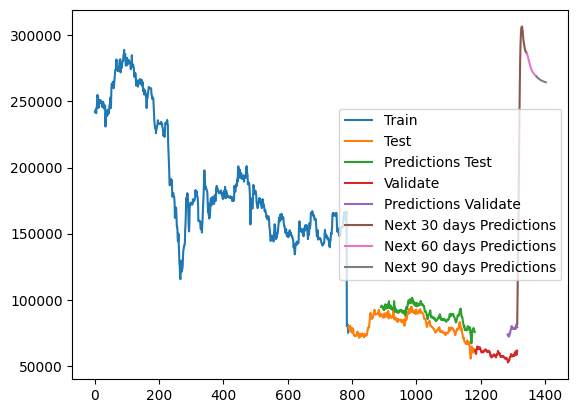

In [202]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))

val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))

val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)

next_30_days_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(next_30_days_index, scaler.inverse_transform(lst_output[:30]))

next_60_days_index = pd.RangeIndex(start=len(df1)+29, stop=len(df1)+59, step=1)
plt.plot(next_60_days_index, scaler.inverse_transform(lst_output[30:60]))

next_90_days_index = pd.RangeIndex(start=len(df1)+59, stop=len(df1)+89, step=1)
plt.plot(next_90_days_index, scaler.inverse_transform(lst_output[60:]))

plt.legend(['Train','Test','Predictions Test','Validate','Predictions Validate','Next 30 days Predictions','Next 60 days Predictions','Next 90 days Predictions'])

plt.show()